<a href="https://colab.research.google.com/github/1gnacio/orgadatos-collab-tp2/blob/ignacio-tp2-conclusionespunto1/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 2 : NLP + Árboles de Decisión

Fecha máxima de entrega: *Lunes 30 de mayo.*

---



In [1]:
import pandas as pd
import numpy as np
from math import pi
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from google.colab import drive
import io
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

## Parte 1 - Análisis de sentimientos

En esta primera parte se trabajará sobre un conjunto de datos de comercio electrónico de ropa de mujer que contiene reseñas escritas por los clientes. El objetivo es realizar un análisis de sentimientos para clasificar las reseñas como positivas o negativas.


### 1. Exploración, preprocesamiento y transformación de datos

a. Realizar Exploración de datos, describiendo las características de los mismos. 

b. Realizar las tareas de limpieza y transformación de datos que sean necesarias.

c. Construir la variable objetivo considerando al atributo Rating de la siguiente forma:
 * Negativo: 1-2-3
 * Positivo: 4-5


#### Exploración del dataset

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#data = pd.read_csv('/content/drive/MyDrive/Organización de datos/Material/Womens Clothing E-Commerce Reviews.csv')
#data = pd.read_csv(io.BytesIO(uploaded['Womens Clothing E-Commerce Reviews.csv']))
data = pd.read_csv('/content/drive/MyDrive/Recursos TP2/Womens Clothing E-Commerce Reviews.csv')
data

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


Como hay una columna que duplica los índices la eliminamos.

In [4]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


Este dataset tiene 10 variables distintas, en donde cada fila presenta una crítica (positiva o negativa) a una prenda de ropa.

| _Variable_              	| _Tipo_                	| _Descripción_                                                   	|
|-------------------------	|-----------------------	|-----------------------------------------------------------------	|
| Clothing ID             	|                       	| ID de la prenda                                                 	|
| Age                     	| Cuantitativa continua 	| Edad de la persona que hace la crítica                          	|
| Title                   	| Cualitativa nominal   	| Título de la crítica                                            	|
| Review Text             	| Cualitativa           	| Texto de la crítica                                             	|
| Rating                  	| Cuantitativa discreta 	| Puntuación de 1 a 5                                             	|
| Recommended IND         	| Cualitativa binaria   	|                                                                 	|
| Positive Feedback Count 	| Cuantitativa discreta 	|                                                                 	|
| Division Name           	| Cualitativa nominal   	| División a la que pertenece la prenda                           	|
| Department Name         	| Cualitativa nominal   	| Departamento (dentro de la división) al que pertenece la prenda 	|
| Class Name              	| Cualitativa nominal   	| Clase (dentro del departamento) a la que pertenece la prenda    	|

Sobre las variables cualitativas, vemos para _Division Name_ y _Department Name_ la cantidad de registros sobre cada una.

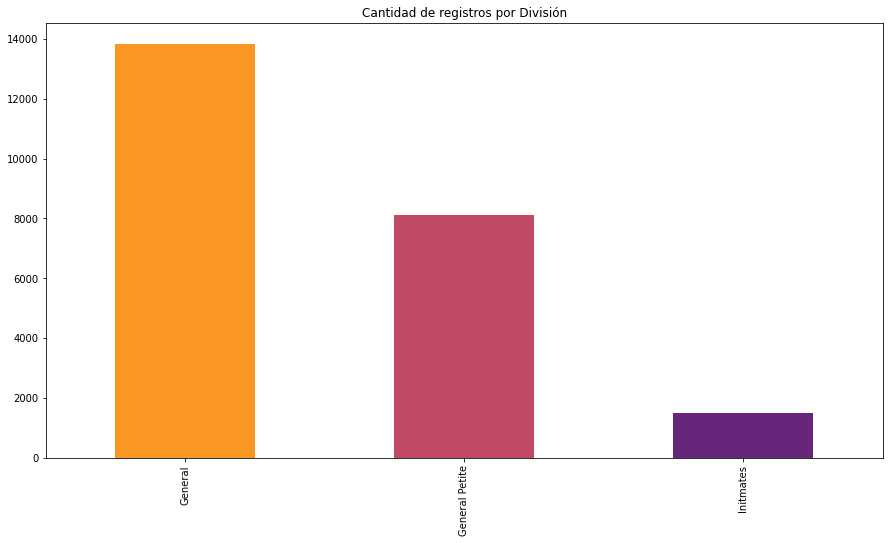

In [5]:
colores = sns.color_palette("inferno_r", 3)
data['Division Name'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8), title='Cantidad de registros por División')
plt.show()

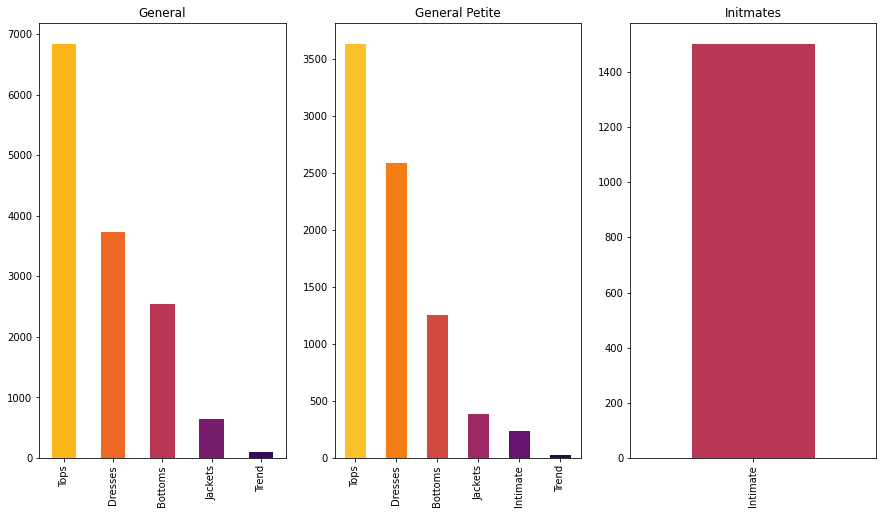

In [6]:
fig, axarr=plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
data[data['Division Name']=='General']['Department Name'].value_counts().plot.bar(title='General', color=sns.color_palette("inferno_r", 5), ax=axarr[0])
data[data['Division Name']=='General Petite']['Department Name'].value_counts().plot.bar(title='General Petite', color=sns.color_palette("inferno_r", 6), ax=axarr[1])
data[data['Division Name']=='Initmates']['Department Name'].value_counts().plot.bar(title='Initmates', color=sns.color_palette("inferno_r", 1), ax=axarr[2])
plt.show()

Respecto a _Class Name_ hacemos una suma de la cantidad de apariciones agrupado por departamento y división.

In [7]:
data.groupby(['Division Name', 'Department Name'])['Class Name'].value_counts()

Division Name   Department Name  Class Name    
General         Bottoms          Pants              835
                                 Jeans              787
                                 Skirts             601
                                 Shorts             317
                                 Casual bottoms       2
                Dresses          Dresses           3730
                Jackets          Jackets            397
                                 Outerwear          248
                Tops             Knits             3259
                                 Blouses           1993
                                 Sweaters           900
                                 Fine gauge         685
                Trend            Trend               96
General Petite  Bottoms          Pants              553
                                 Jeans              360
                                 Skirts             344
                Dresses          Dresses           2589


Para las variables cuantitavivas realizamos un histograma para la variable _Age_ y uno gráfico de barras para _Rating_.

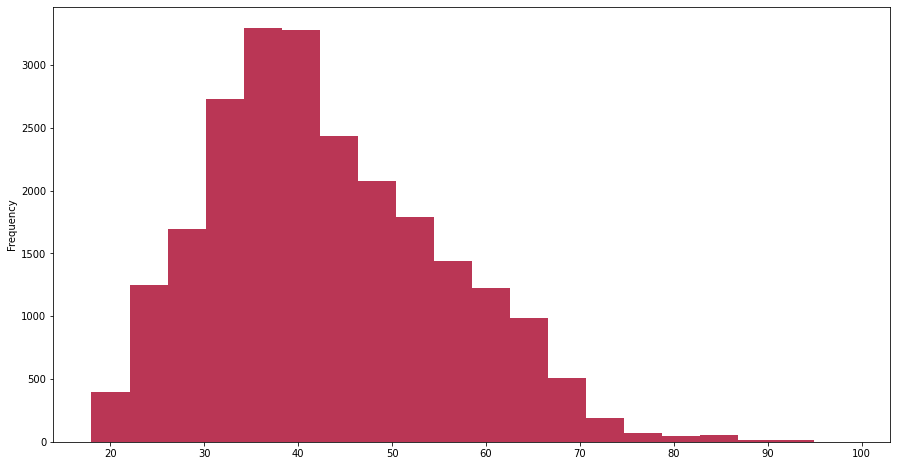

In [8]:
data['Age'].plot.hist(bins=20, figsize=(15,8), color=['#BA3655'])
plt.show()

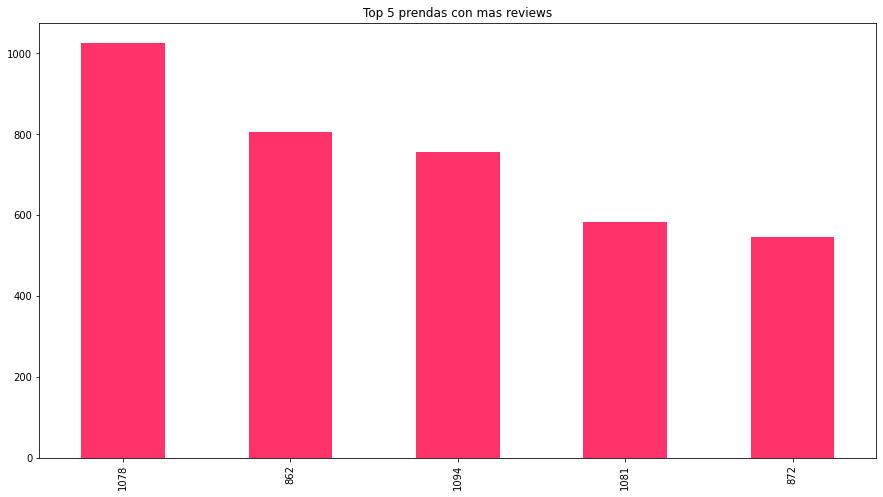

In [9]:
ax = data['Clothing ID'].value_counts().sort_values(ascending=False).head(5).plot.bar(figsize=(15,8), color=['#FF336A'])
ax.set_title('Top 5 prendas con mas reviews')
plt.show()

#### Limpieza y transformación

##### Comenzamos por las variables cuantitativas



Vemos la cantidad de valores nulos (NaN) en el dataset.

In [10]:
data.isna().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

Para éste tipo de variable no hay datos nulos, revisamos que no haya datos nulos (distintos de NaN, como 0 por ejemplo) u outliers. Para eso vemos las medidas de resumen de las variables cuantitativas del dataset.

In [11]:
cuantitativas = data[['Age', 'Rating', 'Positive Feedback Count']]
cuantitativas.describe()

,Age,Rating,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000
mean,43.198544,4.196032,2.535936
std,12.279544,1.110031,5.702202
min,18.000000,1.000000,0.000000
25%,34.000000,4.000000,0.000000
50%,41.000000,5.000000,1.000000
75%,52.000000,5.000000,3.000000
max,99.000000,5.000000,122.000000


Por el lado de los valores mínimos no se ve nada raro, por el lado de los máximos sí. Para sacar los outliers vamos a realizar un análisis univariado calculando el z_score.

In [12]:
# z_score edad
data['z_Age']=st.zscore(data.Age)

# z_score modificado Rating
data['z_Rating']=st.zscore(data.Rating)

# z_score modificado Positive Feedback Count
data.rename(columns={'Positive Feedback Count':'Positive_Feedback_Count'}, inplace=True)
data['z_PFC']=st.zscore(data.Positive_Feedback_Count)

data[['Age', 'Rating', 'Positive_Feedback_Count', 'z_Age', 'z_Rating', 'z_PFC']]

,Age,Rating,Positive_Feedback_Count,z_Age,z_Rating,z_PFC
0,33,4,0,-0.830549,-0.176604,-0.444739
1,34,5,4,-0.749111,0.724291,0.256760
2,60,3,0,1.368277,-1.077499,-0.444739
3,50,5,0,0.553897,0.724291,-0.444739
4,47,5,6,0.309583,0.724291,0.607509
...,...,...,...,...,...,...
23481,34,5,0,-0.749111,0.724291,-0.444739
23482,48,3,0,0.391021,-1.077499,-0.444739
23483,31,3,1,-0.993425,-1.077499,-0.269364
23484,28,3,2,-1.237739,-1.077499,-0.093990


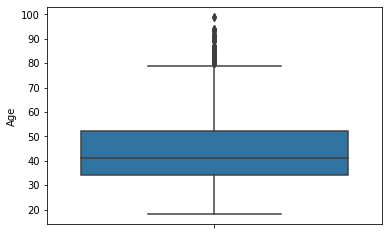

In [13]:
sns.boxplot(y=data['Age'])

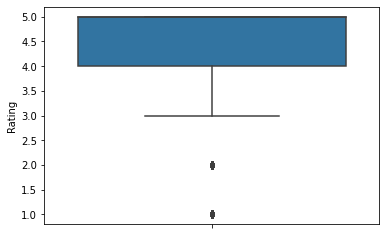

In [14]:
sns.boxplot(y=data['Rating'])

In [15]:
data['Rating'].value_counts()

5    13131
4     5077
3     2871
2     1565
1      842
Name: Rating, dtype: int64

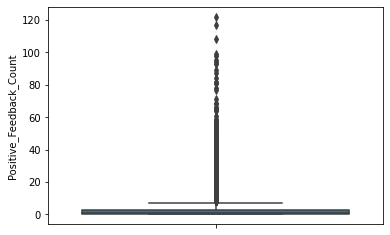

In [16]:
sns.boxplot(y=data['Positive_Feedback_Count'])

Verifico para cada variable que `abs(z_score) < 3`. Revisamos los outliers para cada variable.



In [17]:
data[abs(data['z_Age']) >= 3][['Age', 'z_Age']].sort_values(by='z_Age', ascending=False)

,Age,z_Age
8327,99,4.544358
11545,99,4.544358
18563,94,4.137168
18036,94,4.137168
6543,94,4.137168
...,...,...
21719,81,3.078474
22085,81,3.078474
5469,81,3.078474
17611,81,3.078474


In [18]:
data[abs(data['z_Rating']) >= 3][['Rating', 'z_Rating']]

,Rating,z_Rating


In [19]:
data[abs(data['z_PFC']) >= 3][['Positive_Feedback_Count', 'z_PFC']].sort_values(by='Positive_Feedback_Count', ascending=False)

,Positive_Feedback_Count,z_PFC
7218,122,20.950962
1294,117,20.074089
7765,108,18.495718
19094,99,16.917346
13210,98,16.741972
...,...,...
2467,20,3.062753
7630,20,3.062753
13522,20,3.062753
21634,20,3.062753


El dataset en total tiene 23486 registros, de los cuales 529 (como mucho, ya que puede haber algún repetido entre los outliers de _Age_ y _Positive Feedback Count_) son outliers según el cálculo del z_score, lo que representa sólo un 2.25%. Como la edad y el positive feedback no impactan en la validez de la review, los consideramos para el analisis.

Finalmente, eliminamos las columnas agregadas.

In [20]:
data.drop(columns=['z_Age', 'z_Rating', 'z_PFC'], inplace=True)

##### Seguimos por las cualitativas

Vemos la cantidad de valores nulos (NaN) en el dataset.

In [21]:
data.isna().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive_Feedback_Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

Empezamos por llenar la división, departamento y clase.

In [22]:
data.groupby(['Class Name'])['Department Name'].value_counts()

Class Name      Department Name
Blouses         Tops               3097
Casual bottoms  Bottoms               2
Chemises        Intimate              1
Dresses         Dresses            6319
Fine gauge      Tops               1100
Intimates       Intimate            154
Jackets         Jackets             704
Jeans           Bottoms            1147
Knits           Tops               4843
Layering        Intimate            146
Legwear         Intimate            165
Lounge          Intimate            691
Outerwear       Jackets             328
Pants           Bottoms            1388
Shorts          Bottoms             317
Skirts          Bottoms             945
Sleep           Intimate            228
Sweaters        Tops               1428
Swim            Intimate            350
Trend           Trend               119
Name: Department Name, dtype: int64

In [23]:
data.groupby(['Class Name'])['Division Name'].value_counts()

Class Name      Division Name 
Blouses         General           1993
                General Petite    1104
Casual bottoms  General              2
Chemises        Initmates            1
Dresses         General           3730
                General Petite    2589
Fine gauge      General            685
                General Petite     415
Intimates       Initmates          154
Jackets         General            397
                General Petite     307
Jeans           General            787
                General Petite     360
Knits           General           3259
                General Petite    1584
Layering        Initmates          146
Legwear         Initmates          165
Lounge          Initmates          458
                General Petite     233
Outerwear       General            248
                General Petite      80
Pants           General            835
                General Petite     553
Shorts          General            317
Skirts          General          

En base a esto hacemos un diccionario para llenar los departamentos, ya que no hay repetidos.

In [24]:
dict_dep = {'Blouses': 'Tops', 'Casual bottoms': 'Bottoms', 'Chemises': 'Intimate', 'Dresses': 'Dresses', 'Fine gauge': 'Tops', 'Intimates': 'Intimate', \
            'Jackets': 'Jackets', 'Jeans': 'Bottoms', 'Knits': 'Tops', 'Layering': 'Intimate', 'Legwear': 'Intimate', 'Lounge': 'Intimate', 'Outerwear': 'Jackets', \
            'Pants': 'Bottoms', 'Shorts': 'Bottoms', 'Skirts': 'Bottoms', 'Sleep': 'Intimate', 'Sweaters': 'Tops', 'Swim': 'Intimate', 'Trend': 'Trend'}

In [25]:
dict_dep.keys()

dict_keys(['Blouses', 'Casual bottoms', 'Chemises', 'Dresses', 'Fine gauge', 'Intimates', 'Jackets', 'Jeans', 'Knits', 'Layering', 'Legwear', 'Lounge', 'Outerwear', 'Pants', 'Shorts', 'Skirts', 'Sleep', 'Sweaters', 'Swim', 'Trend'])

In [26]:
data.isna().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive_Feedback_Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [27]:
data.loc[data['Class Name'].isna()]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive_Feedback_Count,Division Name,Department Name,Class Name
9444,72,25,My favorite socks!!!,"I never write reviews, but these socks are so ...",5,1,0,NaN,NaN,NaN
13767,492,23,So soft!,I just love this hoodie! it is so soft and com...,5,1,1,NaN,NaN,NaN
13768,492,49,Wardrobe staple,Love this hoodie. so soft and goes with everyt...,5,1,0,NaN,NaN,NaN
13787,492,48,NaN,NaN,5,1,0,NaN,NaN,NaN
16216,152,36,Warm and cozy,"Just what i was looking for. soft, cozy and warm.",5,1,0,NaN,NaN,NaN
16221,152,37,Love!,I am loving these. they are quite long but are...,5,1,0,NaN,NaN,NaN
16223,152,39,"""long and warm""",These leg warmers are perfect for me. they are...,5,1,0,NaN,NaN,NaN
18626,184,34,Nubby footless tights,"These are amazing quality. i agree, size up to...",5,1,5,NaN,NaN,NaN
18671,184,54,New workhorse,These tights are amazing! if i care for them w...,5,1,0,NaN,NaN,NaN
20088,772,50,Comfy sweatshirt!,This sweatshirt is really nice! it's oversize...,5,1,0,NaN,NaN,NaN


In [28]:
len(data)

23486

Encontramos 14 registros que no tienen asociado una prenda de vestir (Class name), departamento (Department Name) ni tipo de prenda (Division Name). Al no ser una cantidad significativa (14 sobre 23 mil) no los vamos a considerar para el analisis.

In [29]:
data.drop(index= data[data['Class Name'].isna()].index, inplace=True)
len(data)

23472

Para los casos en que Title o Review Text son nulos, tampoco los vamos a considerar en el analisis. Si uno de los dos es exclusivamente nulo, reemplazamos el valor NaN con su variante no nula. 

In [30]:
len(data[(data['Title'].isna()) & (data['Review Text'].isna())])

843

In [31]:
data.drop(index= data[(data['Title'].isna()) & (data['Review Text'].isna())].index, inplace=True)
len(data)

22629

In [32]:
data['Review Text'].fillna(data['Title'], inplace=True)
data['Title'].fillna(data['Review Text'], inplace=True)

In [33]:
data.loc[data['Review Text'].str.len().sort_values().index]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive_Feedback_Count,Division Name,Department Name,Class Name
7785,820,50,Another beautiful white top,Great fit,5,1,0,General Petite,Tops,Blouses
7236,877,41,Comfy cozy!,Comfy cozy!,4,1,0,General,Tops,Knits
8742,952,48,Beautiful unique sweater,I love birds,4,1,0,General,Tops,Sweaters
859,886,27,Great style!,Great style!,5,1,1,General Petite,Tops,Knits
15653,1089,29,Perfect bride dress,Fits perfect.,5,1,0,General,Dresses,Dresses
...,...,...,...,...,...,...,...,...,...,...
22010,909,53,Never been more disappointed...,"Retailer consistently provides unique, sophist...",1,0,5,General Petite,Tops,Fine gauge
1974,1092,50,Love this dress,One of the things i love most about this dress...,5,1,1,General Petite,Dresses,Dresses
22936,1107,48,Love it!,I love this cotton weave shift dress. it is su...,5,1,1,General Petite,Dresses,Dresses
19304,1103,91,I don't understand this dress,I have been continually disappointed in retail...,1,0,3,General,Dresses,Dresses


Observamos que las Review Text son reseñas validas para cada prenda, y en donde el Title o el Review Text eran nulos, se reemplazo por su contraparte no nula.

In [34]:
data.loc[data['Title'].str.len().sort_values().index]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive_Feedback_Count,Division Name,Department Name,Class Name
15671,862,30,<3,I ordered this top in rose. (the color is actu...,5,1,0,General,Tops,Knits
20781,1078,29,Eh,"I love the colors of the teal dress, but i wis...",3,0,8,General Petite,Dresses,Dresses
22885,895,33,No,"Bummer, i loved the lacy bell arms and everyth...",1,0,2,General Petite,Tops,Fine gauge
11778,1022,38,Ag,Awesome jeans. cute and comfortable! size down...,5,1,0,General,Bottoms,Jeans
2876,573,34,Ok,I was so excited to receive this in the mail a...,3,0,4,General Petite,Trend,Trend
...,...,...,...,...,...,...,...,...,...,...
126,1133,71,I read the previous reviews and had hoped that...,I read the previous reviews and had hoped that...,4,1,0,General,Jackets,Outerwear
13284,936,67,I love this sweater! i was nervous after readi...,I love this sweater! i was nervous after readi...,5,1,0,General Petite,Tops,Sweaters
9157,907,47,I had been eyeing this sweater since it came i...,I had been eyeing this sweater since it came i...,5,1,0,General,Tops,Fine gauge
13255,1078,30,Beautiful dress; i ended up getting it in both...,Beautiful dress; i ended up getting it in both...,5,1,0,General,Dresses,Dresses


Observamos tambien que los titulos con pocos caracteres, corresponden a reseñas validas para cada prenda.

In [35]:
data['Clothing ID'].value_counts()

1078    987
862     778
1094    735
1081    561
872     519
       ... 
27        1
246       1
557       1
65        1
522       1
Name: Clothing ID, Length: 1172, dtype: int64

In [36]:
data.isna().sum()

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive_Feedback_Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

#### Construccion de variable objetivo en funcion del Rating

Construimos la variable a analizar en base al Rating, donde los ratings entre 1-3 van a ser reviews negativas y entre 4-5 reviews positivas. Llamamos a nuestra variable objetivo _Positive_review_ que toma valores 0 (review negativa) y 1 (review positiva).

In [37]:
data['Positive_review'] = data['Rating']
data.loc[data['Rating'] < 4, 'Positive_review'] = 0
data.loc[data['Rating'] >= 4, 'Positive_review'] = 1

data[['Rating', 'Positive_review']]

,Rating,Positive_review
0,4,1
1,5,1
2,3,0
3,5,1
4,5,1
...,...,...
23481,5,1
23482,3,0
23483,3,0
23484,3,0


In [38]:
data.value_counts(['Positive_review'])

Positive_review
1                  17436
0                   5193
dtype: int64

### 2. Generación y evaluación de modelos 

a. Dividir el conjunto de datos en un 70-30, en donde el 70% de los datos se utilizarán para
entrenar el modelo y el 30% restante para validarlo. 

b. Entrenar los siguientes algoritmos tal que a partir del texto en el campo “Review Text”, pueda clasificar correctamente la crítica como positiva o negativa.
 * Naive Bayes
 * Regresión logística
 * Árboles de decisión
 * Random Forest  

c. Evaluar todos los clasificadores utilizando las métricas, precisión, recall y F1-Score.

d. Seleccionar el modelo con mejor desempeño y evaluarlo utilizando las 5 clases del
atributo Rating en lugar de la clase binaria

#### Generacion de conjunto de prueba y conjunto de entrenamiento

Separamos el dataset original en dos subsets, donde uno representa el 70% de los registros que van a ser utilizados para entrenar el modelo y el otro 30% restante se utilizara para prueba.

In [39]:
data_cpy = data.copy()
data_cpy.rename(columns={'Review Text':'Review_Text'}, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data_cpy.Review_Text, data_cpy.Positive_review, test_size=0.30, random_state=25, shuffle=True)


In [40]:
y_train.value_counts()

1    12241
0     3599
Name: Positive_review, dtype: int64

In [41]:
y_test.value_counts()

1    5195
0    1594
Name: Positive_review, dtype: int64

In [42]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train)
corpus = vectorizer.get_feature_names_out()

transformer = TfidfTransformer(smooth_idf=True)
transformer.fit_transform(X.toarray()).toarray()

vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus)

<12164x12164 sparse matrix of type '<class 'numpy.float64'>'
	with 12164 stored elements in Compressed Sparse Row format>

#### Generacion de modelos

A continuacion generamos los siguientes modelos:



 * Naive Bayes
 * Regresión logística
 * Árboles de decisión
 * Random Forest  



##### Naive bayes

In [43]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=0.005))

model.fit(X_train, y_train)

predicted_categories = model.predict(X_test)

nb_acc = accuracy_score(y_test, predicted_categories)
nb_recall = recall_score(y_test, predicted_categories)
nb_f1 = f1_score(y_test, predicted_categories)

print("La precision es {}".format(nb_acc))

print("El recall es {}".format(nb_recall))

print("F1 es {}".format(nb_f1))


La precision es 0.8400353513035793
El recall es 0.9738209817131858
F1 es 0.9030703320242771


In [44]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

model.fit(X_train, y_train)

predicted_categories = model.predict(X_test)

nb_acc_paramless = accuracy_score(y_test, predicted_categories)
nb_recall_paramless = recall_score(y_test, predicted_categories)
nb_f1_paramless = f1_score(y_test, predicted_categories)

print("La precision es {}".format(nb_acc_paramless))

print("El recall es {}".format(nb_recall_paramless))

print("F1 es {}".format(nb_f1_paramless))

La precision es 0.7775813816467816
El recall es 0.9994225216554379
F1 es 0.873045232890533


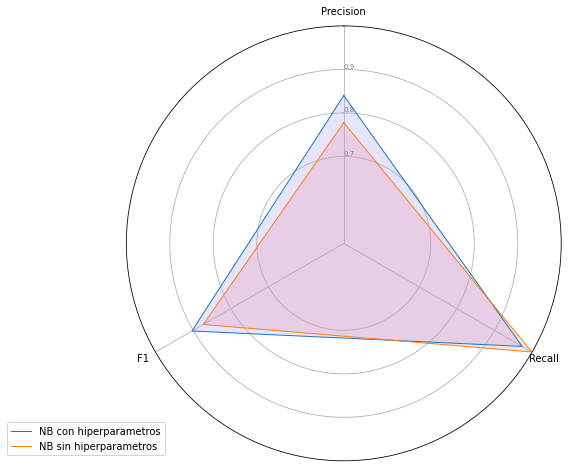

<Figure size 1000x1000 with 0 Axes>

In [45]:
df = pd.DataFrame({
'group': ['A','B'],
'Precision': [nb_acc, nb_acc_paramless],
'Recall': [nb_recall, nb_recall_paramless],
'F1': [nb_f1, nb_f1_paramless],
})
 
categories=list(df)[1:]
N = len(categories)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111, polar=True) 
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
plt.yticks([0.7,0.8,0.9], ["0.7","0.8","0.9"], color="grey", size=7)
plt.ylim(0.5,1)

values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="NB con hiperparametros")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="NB sin hiperparametros")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

plt.show()

##### Regresión logística

In [46]:
model = make_pipeline(TfidfVectorizer(), LogisticRegression(penalty="l1", solver="liblinear"))

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories_positive = model.predict(X_test)

lr_acc = accuracy_score(y_test, predicted_categories_positive)
lr_recall = recall_score(y_test, predicted_categories_positive, average="weighted")
lr_f1 = f1_score(y_test, predicted_categories_positive, average="weighted")

print("La precision es {}".format(lr_acc))

print("El recall es {}".format(lr_recall))

print("F1 es {}".format(lr_f1))

La precision es 0.8805420533215496
El recall es 0.8805420533215496
F1 es 0.8753943220192902


In [47]:
model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter = 300))

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories = model.predict(X_test)

lr_acc_paramless = accuracy_score(y_test, predicted_categories)
lr_recall_paramless = recall_score(y_test, predicted_categories, average="weighted")
lr_f1_paramless = f1_score(y_test, predicted_categories, average="weighted")

print("La precision es {}".format(lr_acc_paramless))

print("El recall es {}".format(lr_recall_paramless))

print("F1 es {}".format(lr_f1_paramless))

La precision es 0.877301517160112
El recall es 0.877301517160112
F1 es 0.8701543683732536


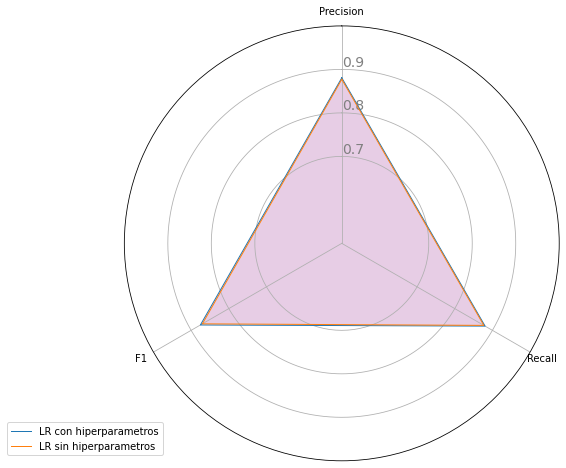

<Figure size 1000x1000 with 0 Axes>

In [48]:
df = pd.DataFrame({
'group': ['A','B'],
'Precision': [lr_acc, lr_acc_paramless],
'Recall': [lr_recall, lr_recall_paramless],
'F1': [lr_f1, lr_f1_paramless],
})
 
categories=list(df)[1:]
N = len(categories)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111, polar=True) 
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
plt.yticks([0.7,0.8,0.9], ["0.7","0.8","0.9"], color="grey", size=14)
plt.ylim(0.5,1)

values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="LR con hiperparametros")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="LR sin hiperparametros")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

plt.show()

##### Árboles de decisión

In [49]:
model = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier(ccp_alpha=0.001))

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories = model.predict(X_test)

dt_acc = accuracy_score(y_test, predicted_categories)
dt_recall = recall_score(y_test, predicted_categories, average="weighted")
dt_f1 = f1_score(y_test, predicted_categories, average="weighted")

print("La precision es {}".format(dt_acc))

print("El recall es {}".format(dt_recall))

print("F1 es {}".format(dt_f1))

La precision es 0.8085137722786861
El recall es 0.8085137722786861
F1 es 0.7928644661555808


In [50]:
model = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories = model.predict(X_test)

dt_acc_paramless = accuracy_score(y_test, predicted_categories)
dt_recall_paramless = recall_score(y_test, predicted_categories, average="weighted")
dt_f1_paramless = f1_score(y_test, predicted_categories, average="weighted")

print("La precision es {}".format(dt_acc_paramless))

print("El recall es {}".format(dt_recall_paramless))

print("F1 es {}".format(dt_f1_paramless))

La precision es 0.7780232729415231
El recall es 0.7780232729415231
F1 es 0.7772635924052164


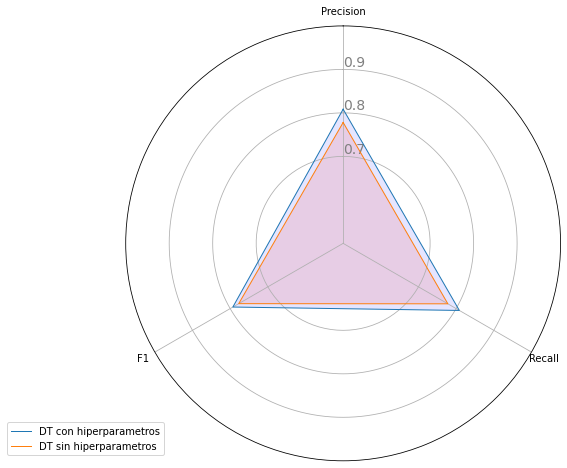

<Figure size 1000x1000 with 0 Axes>

In [51]:
df = pd.DataFrame({
'group': ['A','B'],
'Precision': [dt_acc, dt_acc_paramless],
'Recall': [dt_recall, dt_recall_paramless],
'F1': [dt_f1, dt_f1_paramless],
})
 
categories=list(df)[1:]
N = len(categories)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111, polar=True) 
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
plt.yticks([0.7,0.8,0.9], ["0.7","0.8","0.9"], color="grey", size=14)
plt.ylim(0.5,1)

values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="DT con hiperparametros")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="DT sin hiperparametros")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

plt.show()

##### Random Forest

In [52]:
model = make_pipeline(TfidfVectorizer(), RandomForestClassifier(criterion="entropy"))

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories = model.predict(X_test)

rf_acc = accuracy_score(y_test, predicted_categories)
rf_recall = recall_score(y_test, predicted_categories, average="weighted")
rf_f1 = f1_score(y_test, predicted_categories, average="weighted")

print("La precision es {}".format(rf_acc))

print("El recall es {}".format(rf_recall))

print("F1 es {}".format(rf_f1))

La precision es 0.8108705258506408
El recall es 0.8108705258506408
F1 es 0.7639925932231598


In [53]:
model = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories = model.predict(X_test)

rf_acc_paramless = accuracy_score(y_test, predicted_categories)
rf_recall_paramless = recall_score(y_test, predicted_categories, average="weighted")
rf_f1_paramless = f1_score(y_test, predicted_categories, average="weighted")

print("La precision es {}".format(rf_acc_paramless))

print("El recall es {}".format(rf_recall_paramless))

print("F1 es {}".format(rf_f1_paramless))

La precision es 0.8124907939313596
El recall es 0.8124907939313596
F1 es 0.7676886391086581


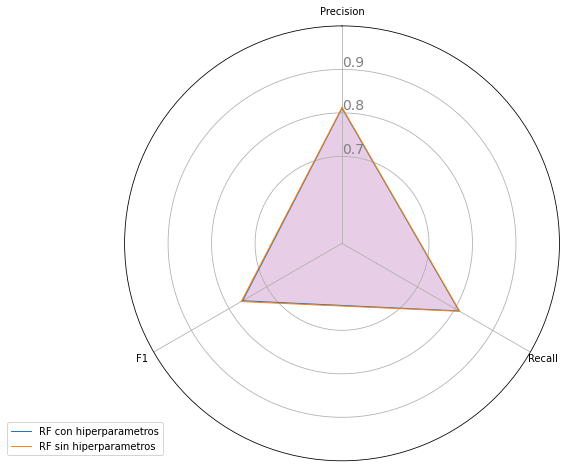

<Figure size 1000x1000 with 0 Axes>

In [54]:
df = pd.DataFrame({
'group': ['A','B'],
'Precision': [rf_acc, rf_acc_paramless],
'Recall': [rf_recall, rf_recall_paramless],
'F1': [rf_f1, rf_f1_paramless],
})
 
categories=list(df)[1:]
N = len(categories)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111, polar=True) 
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
plt.yticks([0.7,0.8,0.9], ["0.7","0.8","0.9"], color="grey", size=14)
plt.ylim(0.5,1)

values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="RF con hiperparametros")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="RF sin hiperparametros")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

plt.show()

#### Analisis de resultados y eleccion de modelo

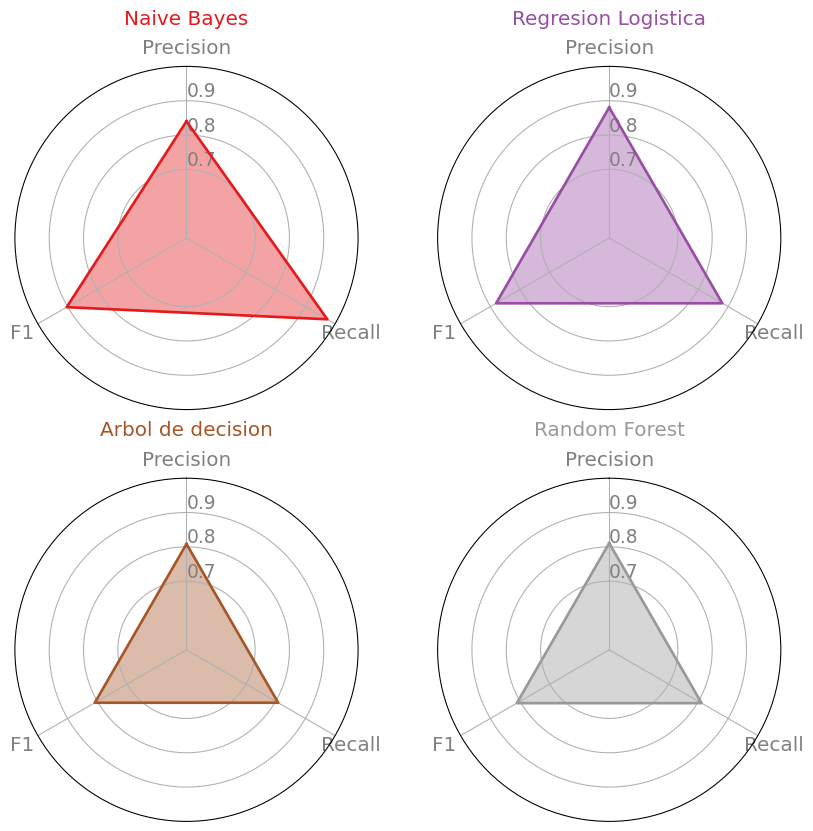

In [55]:
df = pd.DataFrame({
'Modelo': ['Naive Bayes','Regresion Logistica','Arbol de decision','Random Forest'],
'Precision': [nb_acc, lr_acc, dt_acc, rf_acc],
'Recall': [nb_recall, lr_recall, dt_recall, rf_recall],
'F1': [nb_f1, lr_recall, dt_recall, rf_recall]
})
  
def make_spider( row, title, color):

    categories=list(df)[1:]
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(2,2,row+1, polar=True, )

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=15)

    ax.set_rlabel_position(0)
    plt.yticks([0.7,0.8,0.9], ["0.7","0.8","0.9"], color="grey", size=14)
    plt.ylim(0.5,1)

    values=df.loc[row].drop('Modelo').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    plt.title(title, size=15, color=color, y=1.1)

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
my_palette = plt.cm.get_cmap("Set1", len(df.index))
 
for row in range(0, len(df.index)):
    make_spider( row=row, title=df['Modelo'][row], color=my_palette(row))

Nos quedamos con el modelo que promedia mejores metricas, regresion logistica, para intentar predecir la calificacion en base a la crítica. Cambiamos los hiperparametros para que ajuste mejor a variables no binarias, como es el caso de la puntuacion.

In [56]:
X_train_rating, X_test_rating, y_train_rating, y_test_rating = train_test_split(data_cpy.Review_Text, data_cpy.Rating, test_size=0.30, random_state=25, shuffle=True)

vectorizer = CountVectorizer()
X_rating = vectorizer.fit_transform(X_train_rating)
corpus = vectorizer.get_feature_names_out()

transformer = TfidfTransformer(smooth_idf=True)
transformer.fit_transform(X_rating.toarray()).toarray()

vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus)

model = make_pipeline(TfidfVectorizer(), LogisticRegression(solver="sag", multi_class="multinomial"))

model.fit(X_train_rating, y_train_rating)

predicted_categories_rating = model.predict(X_test_rating)

lr_acc_rating = accuracy_score(y_test_rating, predicted_categories_rating)
lr_recall_rating = recall_score(y_test_rating, predicted_categories_rating, average="micro")
lr_f1_rating = f1_score(y_test_rating, predicted_categories_rating, average="micro")

print("La precision es {}".format(lr_acc_rating))

print("El recall es {}".format(lr_recall_rating))

print("F1 es {}".format(lr_f1_rating))

La precision es 0.6404477831786713
El recall es 0.6404477831786713
F1 es 0.6404477831786713


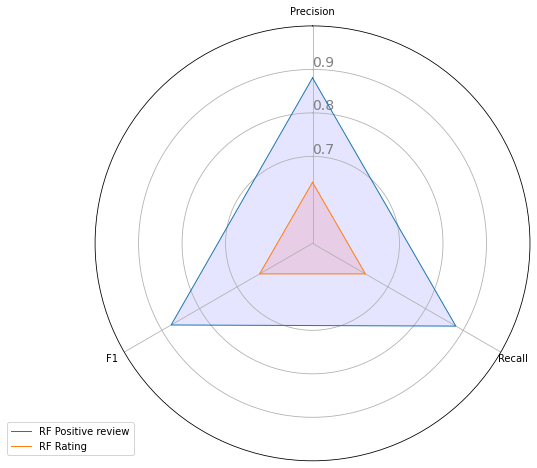

In [57]:
df = pd.DataFrame({
'group': ['A','B'],
'Precision': [lr_acc, lr_acc_rating],
'Recall': [lr_recall, lr_recall_rating],
'F1': [lr_f1, lr_f1_rating],
})

categories=list(df)[1:]
N = len(categories)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
plt.yticks([0.7,0.8,0.9], ["0.7","0.8","0.9"], color="grey", size=14)
plt.ylim(0.5,1)

values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="RF Positive review")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="RF Rating")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

Observamos que su rendimiento fue mucho mas bajo que para *Positive reviews*

### 3. Conclusiones

##### Variable *Positive review*

En cuanto al modelo para la variable binaria *Positive Reviews*, notamos que existe una mala prediccion para las reviews negativas.

Las predicciones negativas tienden a fallar en un 30%, pero al ser aproximadamente un 25% de las reviews, este fallo no llega a apreciarse en el rendimiento del modelo, pero queda en evidencia en la matriz de confusion.

Reducir el dataset original para que el ratio de reviews positivas y negativas sea de 50/50 no consideramos que sea una buena alternativa, ya que se pierden casi la mitad de los registros que se tienen para analizar, por lo que descartamos esa opcion.

In [58]:
y_test.value_counts()

1    5195
0    1594
Name: Positive_review, dtype: int64

Al ser 3 veces mayor la cantidad de reviews positivas que negativas, el modelo tiende a mejorar las predicciones cuando se trata de reviews positivas.

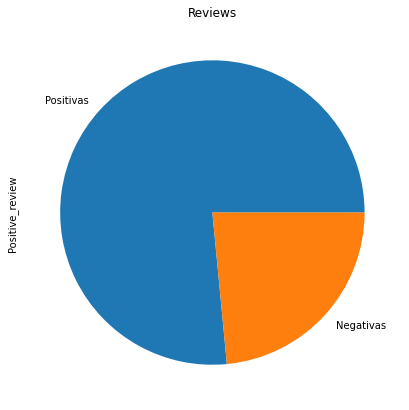

In [59]:
y_test.value_counts().set_axis(['Positivas', 'Negativas']).plot(kind='pie', title='Reviews', figsize=[7,7])

Text(0.5, 24.0, 'predicted')

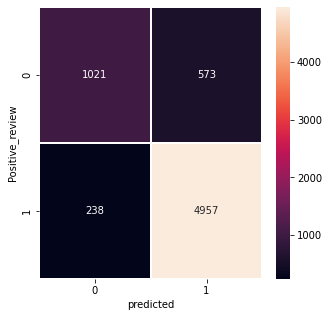

In [60]:
cf_matrix = pd.crosstab(y_test,predicted_categories_positive)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
plt.xlabel('predicted')

Se puede observar que aproximadamente 1/3 de las reviews negativas fueron mal predichas

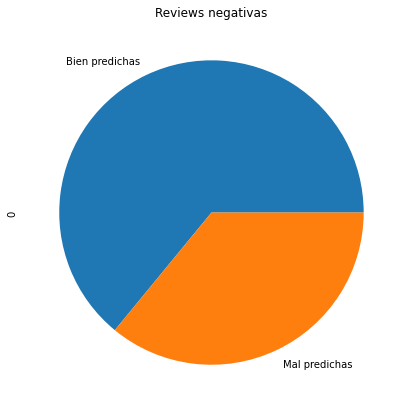

In [61]:
neg_reviews = cf_matrix.loc[0].set_axis(['Bien predichas', 'Mal predichas'])
neg_reviews.plot(kind='pie', title='Reviews negativas', figsize=[7,7])

Mientras que las reviews positivas en general fueron bien predichas

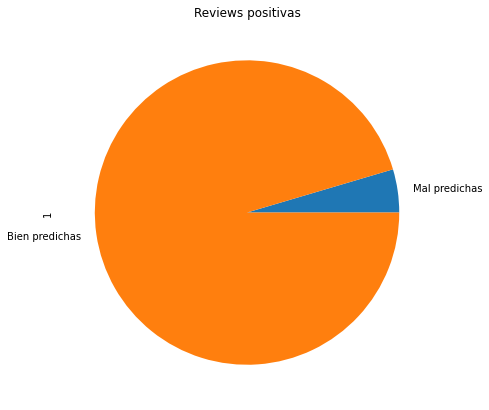

In [62]:
pos_reviews = cf_matrix.loc[1].set_axis(['Mal predichas', 'Bien predichas'])
pos_reviews.plot(kind='pie', title='Reviews positivas', figsize=[7,7])

Habiendo considerado lo anterior, no podemos recomendar el uso de los modelos en un entorno productivo, ya que no predice de forma correcta reviews negativas o de puntuaciones de tres estrellas o menos.

##### Variable *Rating*

Se observa una peor prediccion del modelo cuando se cambia la variable a predecir. Por una parte el dataset contiene porcentajes desiguales para cada rating, donde el rating 5 ocupa mas del 50% del dataset, mientras que rating 1 menos del 5%. Se puede ver en la matriz de confusion como el rating 5 fue predicho con mayor exactitud que el resto, y como la desviacion de predicciones con ratings intermedios (2, 3, 4) tambien mejoran su precision si se acepta un error de +- 1.

No recomendamos reducir el dataset para que todos los ratings tengan una cantidad de registros parecida, ya que el rating mas bajo tiene un 5% de las reviews totales. Si queremos equiparar la cantidad de reviews tenemos que reducir el dataset a un 25% de los registros totales, perdiendo asi demasiada informacion.

In [63]:
data_cpy['Rating'].value_counts()

5    12528
4     4908
3     2823
2     1549
1      821
Name: Rating, dtype: int64

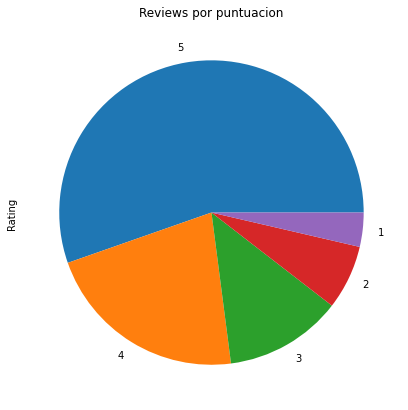

In [64]:
data_cpy['Rating'].value_counts().plot(kind='pie', title='Reviews por puntuacion', figsize=[7,7])

Vemos que existe un sesgo en la informacion, donde la mayoria de reviews son de 5 estrellas, afectando la prediccion de nuestro modelo y solo teniendo buen rendimiento para el rating 5.

Text(0.5, 24.0, 'predicted')

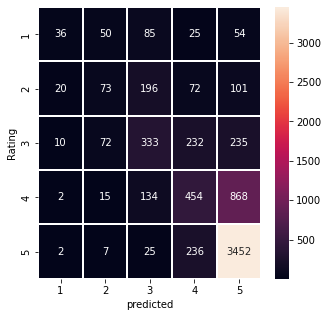

In [65]:
cf_matrix = pd.crosstab(y_test_rating,predicted_categories_rating)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
plt.xlabel('predicted')

Por otro lado se observa que para los ratings mas bajos (1, 2) el modelo intenta adivinar a que categoria pertenece.

En consideracion, no recomendamos el modelo creado para un entorno productivo, ya que en general no va a predecir de forma correcta los ratings 1-4.

##Parte 2 - Arboles de decision

##### Exploracion, preprocesamiento y transformacion de datos

En esta segunda parte se trabajará sobre un conjunto de datos de reservas de hotel. El
objetivo es predecir cuál de ellas va a ser cancelada. Para resolver este problema se utilizarán
árboles de decisión.

In [66]:
data = pd.read_csv('/content/drive/MyDrive/Recursos TP2/hotel_bookings.csv')
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


Este dataset tiene 32 columnas distintas, en donde cada una representa una reservación de hotel. A continuación se realiza una breve descripción de cada variable:  

**ADR (Average Daily Rate):** [Cuantitativa continua] Promedio diario  
**Adults:** [Cuantitativa discreta]Cantidad de adultos  
**Agent:** [Cualitativa categórica] ID de la agencia de viaje  
**ArrivalDateDayOfMonth:** [Cuantitativa discreta] Día del mes en que ingresan  
**ArrivalDateMonth:** [Cualitativa categórica] Mes en el que ingresan (va desde _January_ hasta _December_)  
**ArrivalDateWeekNumber:** [Cuantitativa discreta] Número de semana de ingreso
**ArrivalDateYear:** [Cuantitativa discreta] Año de ingreso  
**AssignedRoomType:** [Cualitativa categórica] Codigo para el tipo de habitación asignada  
**Babies:** [Cuantitativa discreta] Cantidad de bebés  
**BookingChanges:** [Cuantitativa discreta] Cantidad de cambios desde la reserva hasta el check-in o la cancelación  
**Children:** [Cuantitativa discreta] Cantidad de niños  
**Company:** [Cualitativa categórica] ID de la entidad responsable del pago  
**Country:** [Cualitativa categórica] País de origen  
**CustomerType:** [Cualitativa categórica] Tipo de reserva entre los siguientes tipos: _Contract_, _Group_, _Transient_ o _Transient-party_  
**DaysInWaitingList:** [Cuantitativa discreta] Cantidad de días hasta que fue confirmada la reserva  
**DepositType:** [Cualitativa categórica] Indica si se hizo una seña de garantía  
**DistributionChannel:** [Cualitativa categórica] Puede ser _TA_ (Travel Agents) o _TO_ (Tour Operators)  
**IsCanceled:** [Cualitativa categórica] Valor que indica si la reserva fue cancelada (1) o no (0)  
**IsReapeatedGuest:** [Cualitativa categórica] Indica si la persona ya hizo anteriormente una reserva (1) o no (0)  
**LeadTime:** [Cuantitativa discreta] Cantidad de días entre la reserva y el check-in  
**MarketSegment:** [Cualitativa categórica] Puede ser _TA_ (Travel Agents) o _TO_ (Tour Operators)  
**Meal:** [Cualitativa categórica] Tipo de comida reservada, viene por paquetes (Undefined/SC – no meal package;
BB – Bed & Breakfast;
HB – Half board (breakfast and one
other meal – usually dinner);
FB – Full board (breakfast, lunch and
dinner))  
**PreviousBookingsNotCanceled:** [Cuantitativa discreta] Cantidad de reservas anteriores no canceladas  
**PreviousCancellations:** [Cuantitativa discreta] Cantidad de reservas anteriores canceladas  
**RequiredCardParkingSpaces:** [Cuantitativa discreta] Cantidad de espacios de estacionamientos requeridos  
**ReservationStatus:** [Cualitativa categórica] Último estado de la reservación, hay tres categorias disponibles: Canceled – booking was canceled by
the customer;
Check-Out – customer has checked in
but already departed;
No-Show – customer did not check-in
and did inform the hotel of the reason
why  
**ReservationStatusDate:** [Cualitativa] Fecha en la fue establecido el último estado  
**ReservedRoomType:** [Cualitativa categórica] Código del tipo de habitación reservada  
**StaysInWeekendNights:** [Cuantitativa discreta] Cantidad de noches de estadía durante fines de semana  
**StaysInWeekNights:** [Cuantitativa discreta] Cantidad de noches de estadía durante la semana  
**TotalOfSpecialRequests:** [Cuantitativa discreta] Cantidad de pedidos especiales

In [67]:
data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


**Análisis para las variables cualitativas**

Dado que son más de diez variables cualitativas, para cinco de ellas realizaremos un gráfico para visualizar sus valores.

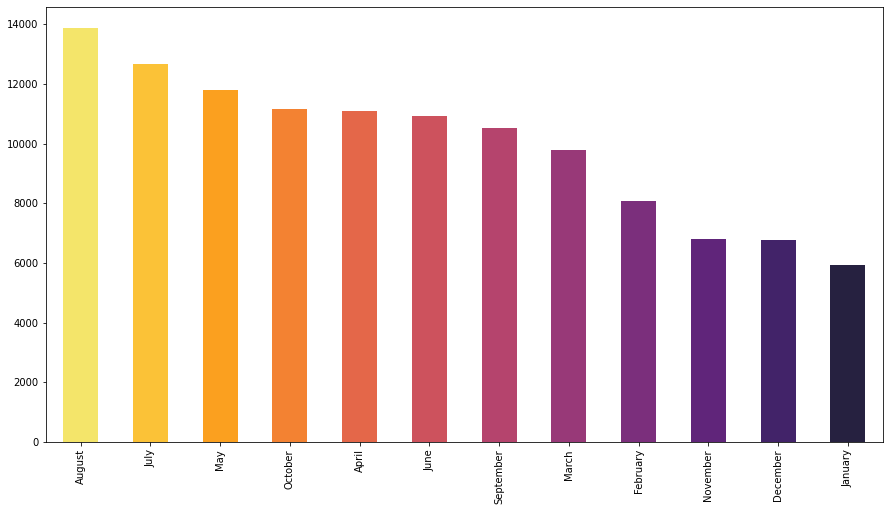

In [68]:
colores = sns.color_palette("inferno_r", 12)
data['arrival_date_month'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8))
plt.show()

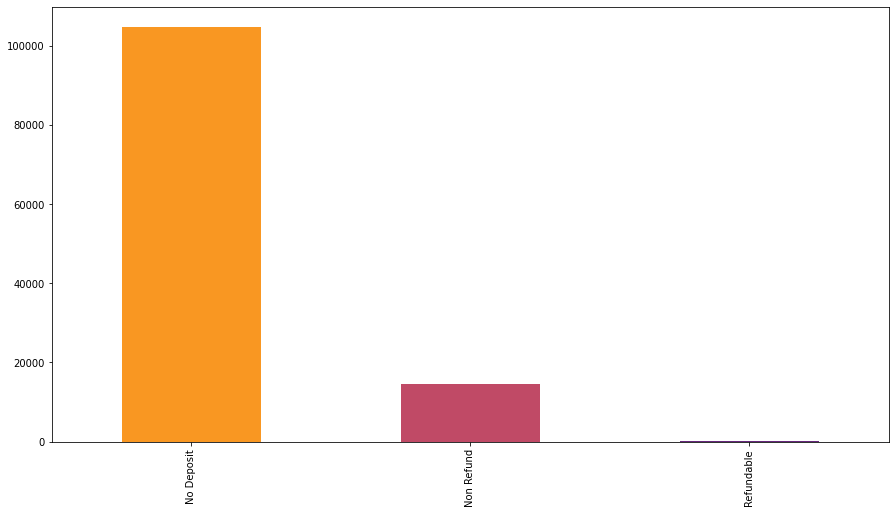

In [69]:
colores = sns.color_palette("inferno_r", 3)
data['deposit_type'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8))
plt.show()

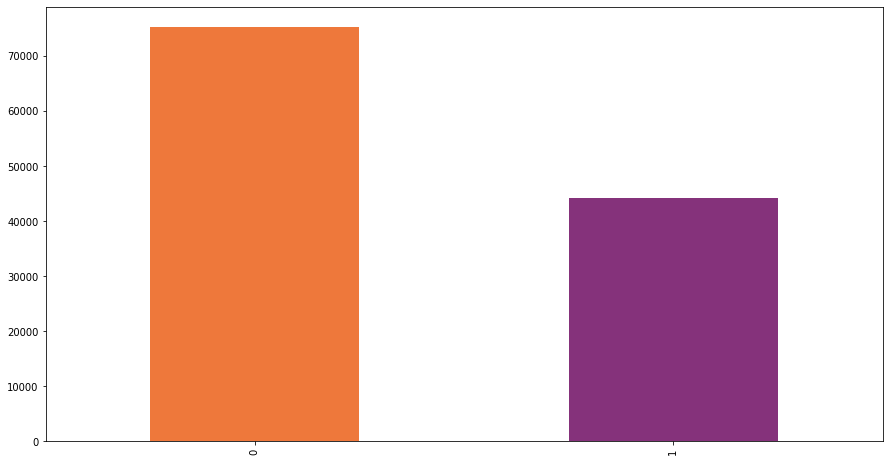

In [70]:
colores = sns.color_palette("inferno_r", 2)
data['is_canceled'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8))
plt.show()

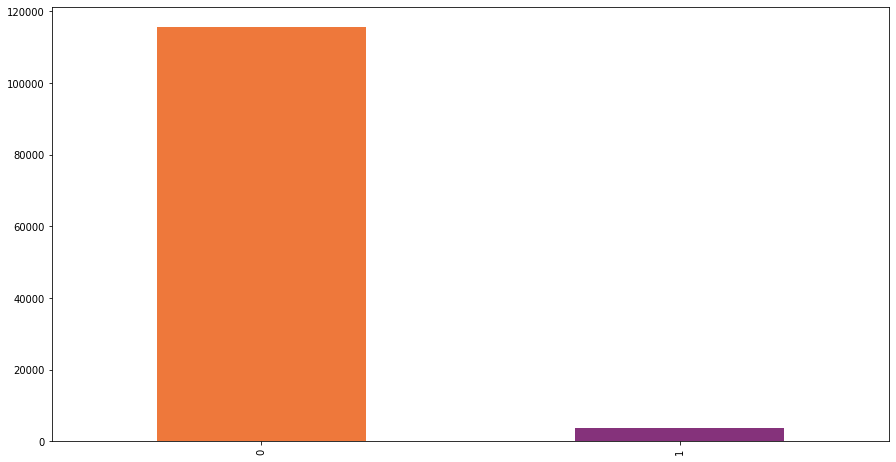

In [71]:
colores = sns.color_palette("inferno_r", 2)
data['is_repeated_guest'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8))
plt.show()

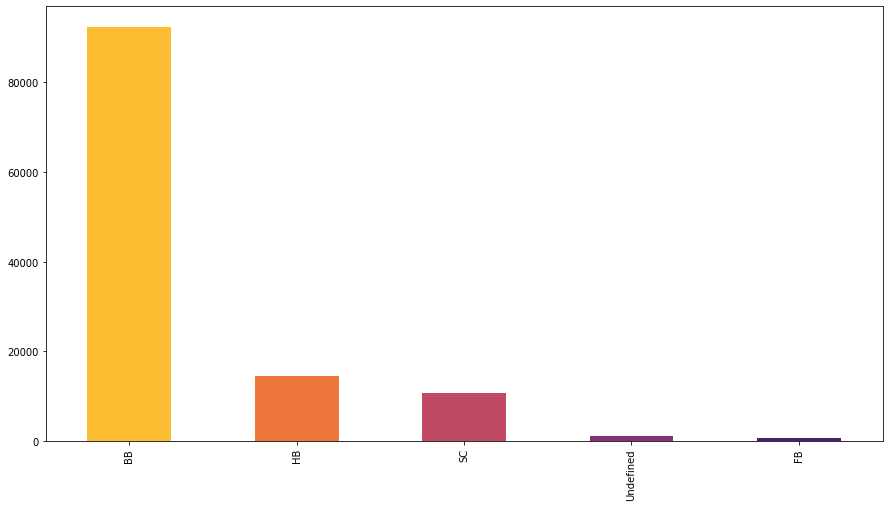

In [72]:
colores = sns.color_palette("inferno_r", 5)
data['meal'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8))
plt.show()

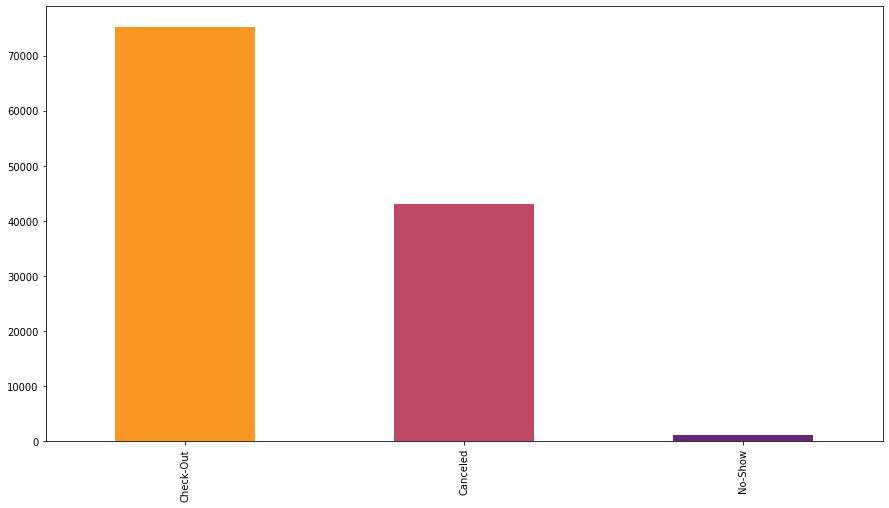

In [73]:
colores = sns.color_palette("inferno_r", 3)
data['reservation_status'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8))
plt.show()

A continuación analizaremos si hay valores nulos

In [74]:
data.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Analizaremos qué hacer respecto a los nulls de _company_ ya que es la variable que más tiene

In [75]:
len(data)

119390

In [76]:
data['company'].unique()

array([ nan, 110., 113., 270., 178., 240., 154., 144., 307., 268.,  59.,
       204., 312., 318.,  94., 174., 274., 195., 223., 317., 281., 118.,
        53., 286.,  12.,  47., 324., 342., 373., 371., 383.,  86.,  82.,
       218.,  88.,  31., 397., 392., 405., 331., 367.,  20.,  83., 416.,
        51., 395., 102.,  34.,  84., 360., 394., 457., 382., 461., 478.,
       386., 112., 486., 421.,   9., 308., 135., 224., 504., 269., 356.,
       498., 390., 513., 203., 263., 477., 521., 169., 515., 445., 337.,
       251., 428., 292., 388., 130., 250., 355., 254., 543., 531., 528.,
        62., 120.,  42.,  81., 116., 530., 103.,  39.,  16.,  92.,  61.,
       501., 165., 291., 290.,  43., 325., 192., 108., 200., 465., 287.,
       297., 490., 482., 207., 282., 437., 225., 329., 272.,  28.,  77.,
       338.,  72., 246., 319., 146., 159., 380., 323., 511., 407., 278.,
        80., 403., 399.,  14., 137., 343., 346., 347., 349., 289., 351.,
       353.,  54.,  99., 358., 361., 362., 366., 37

In [77]:
data['company'].fillna(0, inplace=True)

data['company'].unique()

array([  0., 110., 113., 270., 178., 240., 154., 144., 307., 268.,  59.,
       204., 312., 318.,  94., 174., 274., 195., 223., 317., 281., 118.,
        53., 286.,  12.,  47., 324., 342., 373., 371., 383.,  86.,  82.,
       218.,  88.,  31., 397., 392., 405., 331., 367.,  20.,  83., 416.,
        51., 395., 102.,  34.,  84., 360., 394., 457., 382., 461., 478.,
       386., 112., 486., 421.,   9., 308., 135., 224., 504., 269., 356.,
       498., 390., 513., 203., 263., 477., 521., 169., 515., 445., 337.,
       251., 428., 292., 388., 130., 250., 355., 254., 543., 531., 528.,
        62., 120.,  42.,  81., 116., 530., 103.,  39.,  16.,  92.,  61.,
       501., 165., 291., 290.,  43., 325., 192., 108., 200., 465., 287.,
       297., 490., 482., 207., 282., 437., 225., 329., 272.,  28.,  77.,
       338.,  72., 246., 319., 146., 159., 380., 323., 511., 407., 278.,
        80., 403., 399.,  14., 137., 343., 346., 347., 349., 289., 351.,
       353.,  54.,  99., 358., 361., 362., 366., 37

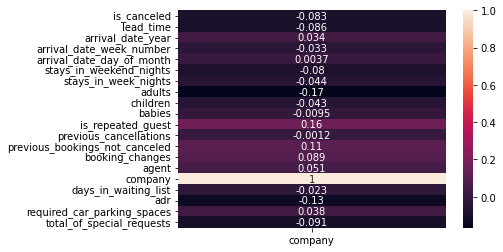

In [78]:
sns.heatmap(data.corr()[['company']],annot=True)

La variable que nos interesa predecir es is_cancelled, se observa que la correlacion entre company - is_cancelled es baja y ademas la mayoria de reservas no tienen compania, decidimos eliminar la columna para continuar con el analisis

In [79]:
data.drop('company', axis=1, inplace=True)
data.isna().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country                             488
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                             16340
days_in_waiting_list                  0


Como los registros con columna nula para 'agent', 'country' y 'children' representan menos del 1% del total de registros, los mantenemos en el dataset como nulos.

A continuación veremos para las variables que contienen strings si hay valores nulos representados por ejemplo con "" o "-"

In [80]:
data.select_dtypes(include=['object']).dtypes

hotel                      object
arrival_date_month         object
meal                       object
country                    object
market_segment             object
distribution_channel       object
reserved_room_type         object
assigned_room_type         object
deposit_type               object
customer_type              object
reservation_status         object
reservation_status_date    object
dtype: object

Debido a la cantidad de variables de este tipo lo hacemos con algunas al azar

In [81]:
data.select_dtypes(include=['object'])['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [82]:
data.select_dtypes(include=['object'])['hotel'].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [83]:
data.select_dtypes(include=['object'])['deposit_type'].unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

Suponemos que no hay strings vacios o con datos incompletos

Correlación de la variable _is_canceled_ con el resto de variables

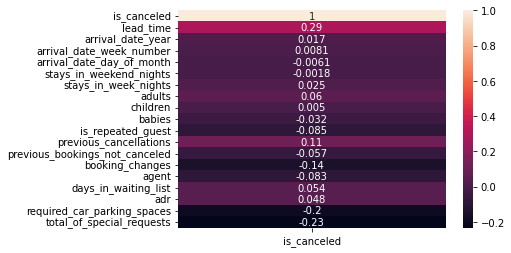

In [84]:
sns.heatmap(data.corr()[['is_canceled']],annot=True)

Se puede ver que las más correlacionadas positivamente son _lead_time_ y _previous_cancellations_, respecto a las más correlacionadas negativamente son _total_of_special_requests_ y _booking_changes_.

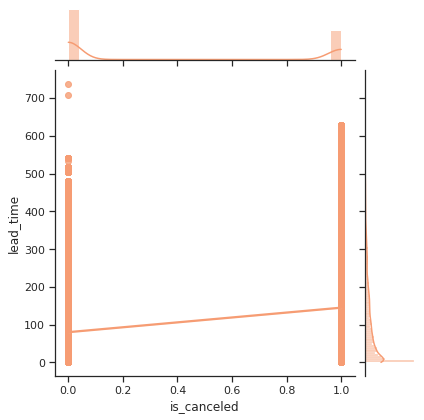

In [85]:
sns.set_theme(style="ticks")
x = data['is_canceled']
y = data['lead_time']

sns.jointplot(x=x, y=y, kind="reg", color="#F69C73")
plt.show()

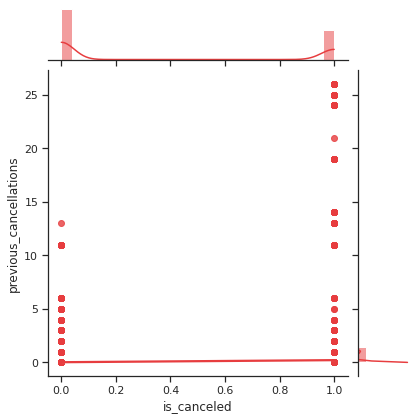

In [86]:
sns.set_theme(style="ticks")
x = data['is_canceled']
y = data['previous_cancellations']

sns.jointplot(x=x, y=y, kind="reg", color="#E73D3F")
plt.show()

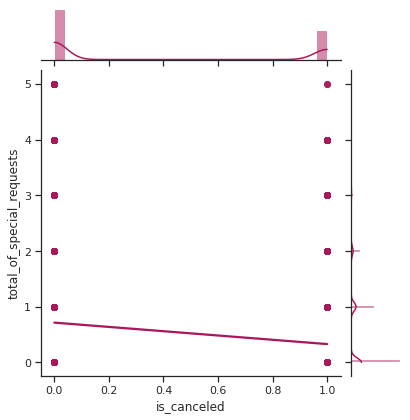

In [87]:
sns.set_theme(style="ticks")
x = data['is_canceled']
y = data['total_of_special_requests']

sns.jointplot(x=x, y=y, kind="reg", color="#AA185A")
plt.show()

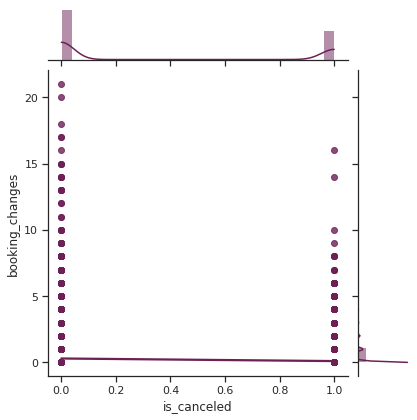

In [88]:
sns.set_theme(style="ticks")
x = data['is_canceled']
y = data['booking_changes']

sns.jointplot(x=x, y=y, kind="reg", color="#6D1F56")
plt.show()

Dado que los valores nulos ya fueron analizados y realizar transformaciones para trabajar con árboles no resulta en ningún cambio, sólo realizaremos un análisis de outliers como limpieza del set.

In [89]:
data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,391.000000,5400.000000,8.000000,5.000000


### Generación y evaluación de modelos

En primer lugar, se deberá separar un 20% de los datos para usarlos como conjunto de
evaluación (test set). El conjunto restante (80%) será el de entrenamiento.  

a. Construir un árbol de decisión y optimizar sus hiperparámetros mediante kfold-Cross
Validation para obtener la mejor performance.¿Cuántos folds utilizaron? ¿Qué métrica
consideran adecuada para buscar los parámetros?  

b. Graficar el árbol de decisión con mejor performance encontrado en el punto anterior.  

c. Analizar el árbol de decisión seleccionado describiendo los atributos elegidos, y decisiones evaluadas.  

d. Evaluar la performance del árbol en el conjunto de evaluación, explicar todas las métricas y mostrar la matriz de confusión. Comparar con la performance de entrenamiento.  

e. Entrenar un modelo Random Forest y evaluar su performance sobre los conjuntos de entrenamiento y test. Comparar con el árbol de decisión del punto a)

#### Conjunto de pruebas y de entrenamiento

Separamos un 20% de los datos para test, el resto seran para entrenar el modelo.

In [90]:
features=data.columns.tolist()
features.remove('is_canceled')

target='is_canceled'